# **Transformers learn in-context by gradient descent**
This specific notebook can be used to reproduce the results that assumes the standard token construction i.e. where $e_{2i} = x_i, e_{2i+1} = y_i$. We here show that the Transformer needs to first copy over neighboring tokens after which it can perform gradient descent steps in the following self-attention layers.

In [1]:
!export PATH=$PATH:../../transformer

In [2]:
#@title Imports external sources
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from functools import partial
from scipy.ndimage import rotate
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import time
from typing import Any, MutableMapping, NamedTuple, Tuple
#!pip install --quiet --upgrade tensorflow 
#!pip install --quiet --upgrade jax
#!pip install --quiet --upgrade jaxlib 
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp

#!pip install --quiet -U dm-haiku
#!pip install --quiet -U optax
import haiku as hk
import math
#!pip install --quiet -U ml_collections
from ml_collections import config_dict
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2'] 

In [3]:
#@title Import internal sources (from github)
#!git clone --quiet https://github.com/google-research/self-organising-systems.git /content/self-organising-systems > /dev/null 2>&1
#%cd /content/self-organising-systems/transformers_learn_icl_by_gd
from transformer.src.transformer import Transformer
from transformer.src.data import create_reg_data_classic_token, create_weights
from transformer.src.config import config
from transformer.src.train import *

2024-08-29 16:53:10.107885: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.1 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In the following you can play around with the experimental setup. 
A couple of things to note: 

1.   **use_softmax_only_in_the_first_layer** chooses if we want to use a softmax self-attention in the first layer. This seems to be neccessary to learn to copy in the first layer.  

2. **num_seeds** > 1 will rerun and show results of the experiment with the same config but with multiple seeds. For quick execution set this to 1.

3. The experiments run much quicker when using a GPU or TPU.

In [4]:
#@title Config
use_softmax = False #@param {type:"boolean"}
use_softmax_only_in_the_first_layer = True #@param {type:"boolean"}
num_layers = 2 #@param {type:"integer"}
num_heads = 1 #@param {type:"integer"}
num_seeds = 1 #@param {type:"integer"}

#@title Config
config.classic_token_const = True
config.seed = 0

if use_softmax_only_in_the_first_layer:
  assert use_softmax == False
  
from datetime import datetime
now = datetime.now()
config.local_usage = True
config.distract_size = 0
config.training_steps = 10000
config.training_steps_gd = 10000
config.use_softmax = use_softmax 
config.first_layer_sm = use_softmax_only_in_the_first_layer 
config.use_non_lin_mix = False 

####
config.deq = False
config.att_only_trans = True
####

config.layer_norm = False
config.out_proj = False
config.in_proj = False
config.adam = True
config.pre_train_gd = True
config.dataset_size = 10
config.input_size = 10
config.num_layers = num_layers
config.num_heads = num_heads

config.grad_clip_value = 10
config.lr = 0.001

config.wd = 0.0
config.init_scale = 0.02 / config.num_layers
config.bs = 2048

config.dropout_rate = 0.0
data_creator = vmap(create_reg_data_classic_token,
                    in_axes=(0, None, None, None, None, None),
                    out_axes=0)

config.y_update = False
config.input_range = 1
config.seed = 0

config.gd_deq = True 
config.pos_enc = True
config.pos_enc_size = 10
config.concat_pos_enc = True
config.key_size = 20
config.analyse = False

config.ana_copy  = True
config.num_seeds = num_seeds

change_dataloader()

In [5]:
#@title Utils
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})

import matplotlib.colors as mcolors
colors = pl.colormaps['Dark2'] 
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb') #GFile.open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image."""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def display_learning(train, test=None, gt=None, inter=None, title="train", 
                     title1="Trained TF", title2="Test", 
                     title3='Gradient descent', title4='Interpolated',
                     y_label1 = 'L2 Norm', y_label2 = 'Cosine sim',
                     y_lim_l=0,  y_lim_u=1, single_seeds= False,
                     plot_title = None,
                     y_lim_u2= 1., y_lim_l2=0.,  x_label = 'Training steps',   
                     second_axis=False, color_add=0, rw=10, num_iter_os=None, 
                     allow_download=False, plot_num=1, two_plots=False, 
                     loc_first = 'upper left', label_title="Loss",
                     loc_sec='upper left', yscale_log=False, line="-",
                     color_axis=True, 
                     height=3.5, width = 4, ax1=None, ax2=None):
  
  """Update learning curve image."""

  train_list = train
  train = np.array(train)
  num_seeds_train = train.shape[0]
  train_std = np.std(train, axis=0)
  train = np.mean(train, axis=0)
  
  if test is not None:
    test_list = test
    test_std = np.std(test, axis=0)
    test = np.mean(test, axis=0)

  if gt is not None:
    gt_list = gt
    gt_std = np.std(gt, axis=0)
    gt = np.mean(gt, axis=0)

  if inter is not None:
    inter_list = inter
    inter_std = np.std(inter, axis=0)
    inter = np.mean(inter, axis=0)

  if plot_num == 1:
    fig, ax1 = pl.subplots()
    ax1.set_xlabel(x_label)
    fig.set_size_inches(width, height)

  
  if test is not None and not second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.1+color_add), alpha=0.2, linewidth='2')
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.1+color_add))
    ax1.plot(x_range[:len(test)], test, color=colors(0.1+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)], test_avg, color=colors(0.1+color_add), label=title2)
      
  if gt is not None:
    if not second_axis:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      #ax1.plot(x_range[:len(gt[:-rw])], gt[:-rw], color=colors(0.2+color_add), alpha=0.3)
      #gt_avg = moving_average(gt, rw)
      ax1.plot(x_range[:len(gt)],gt, color=colors(0.2+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.2+color_add), alpha=0.2, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std,alpha=0.2, facecolor=colors(0.2+color_add))
    else:
      x_range = np.arange(0, num_iter_os, int(num_iter_os/len(gt)))
      ax1.plot(x_range, gt, color=colors(0.6+color_add), label=title3,linewidth='3')
      if len(gt_list) > 1:
        if single_seeds:
          for s in gt_list:
            ax1.plot(x_range, s, color=colors(0.6+color_add), alpha=0.3, linewidth='2', zorder=0)
        else:
          ax1.fill_between(x_range, gt-gt_std, gt+gt_std ,alpha=0.2, facecolor=colors(0.6+color_add))

  if test is not None and second_axis:
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(test)))
    ax1.plot(x_range[:len(test[:-rw])], test[:-rw], color=colors(0.5+color_add), label=title2,linewidth='3')
    #test_avg = moving_average(test, rw)
    #ax1.plot(x_range[:len(test_avg)],test_avg, color=colors(0.5+color_add))
    if len(test_list) > 1:
      if single_seeds:
        for s in test_list:
          ax1.plot(x_range, s, color=colors(0.5+color_add), linewidth='2', alpha=0.3, zorder=0)
      else:
        ax1.fill_between(x_range, test-test_std, test+test_std ,alpha=0.2, facecolor=colors(0.5+color_add))

  if inter is not None and not second_axis:
    print(num_iter_os, int(num_iter_os/len(inter)))
    x_range = np.arange(0, num_iter_os, int(num_iter_os/len(inter)))
    ax1.plot(x_range, inter, color=colors(0.4+color_add), label=title4, linewidth='3', zorder=10)
    if len(inter_list) > 1:
      if single_seeds:
        for s in inter_list:
          ax1.plot(x_range, s, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax1.fill_between(x_range, inter-inter_std, inter+inter_std ,alpha=0.2, facecolor=colors(0.4+color_add), zorder=1)
    #inter_avg = moving_average(inter, rw)
    #ax1.plot(x_range[:len(inter_avg)], inter_avg, color=colors(0.7+color_add), label=title4)

  if second_axis:
    if ax2 is None:
      ax2 = ax1.twinx()
    ax2.set_zorder(0)
    ax1.set_zorder(1)
    ax1.set_frame_on(False)
    #train_avg = moving_average(train, rw)
    #ax2.plot(train[:-rw], color=colors(0.1+color_add), alpha=0.3)
    ax2.plot(x_range, train, color=colors(0.4+color_add), label=title1, linewidth='3')
    ax2.plot(x_range, np.ones_like(train), "--", color="gray", linewidth='0.7')
    if len(train_list) > 1:
      if single_seeds:
        for s in train_list:
          ax1.plot(x_range, s, line, color=colors(0.4+color_add), alpha=0.3, linewidth='2', zorder=0)
      else:
        ax2.fill_between(x_range, train-train_std, train+train_std ,alpha=0.2, facecolor=colors(0.4+color_add))

    if color_axis:
      ax2.yaxis.label.set_color(colors(0.4+color_add))
    else:
      legend2 = ax2.legend(loc='upper right', framealpha=0.99, facecolor='white')
      legend2.set_zorder(100)
    ax2.spines['top'].set_visible(False)
  else:
    #train_avg = moving_average(train, rw)
    if line != "-":
      ax1.scatter(x_range, train, s=[100 for _ in x_range], 
                  marker="+", color=colors(0.3+color_add), alpha=1, label=title1, zorder=3, linewidths=3)
    else:
      ax1.plot(x_range, train, line, color=colors(0.3+color_add), label=title1, linewidth='3', zorder=11)
    #ax1.plot(x_range[:len(train_avg)], train_avg, line, color=colors(0.3+color_add), label=title1)
    if len(train_list) > 1:
      if single_seeds:
          for s in train_list:
            ax1.plot(x_range, s, line, color=colors(0.3+color_add), alpha=0.3, linewidth='2', zorder=0)
      else: 
        ax1.fill_between(x_range, train-train_std, train+train_std,
                       alpha=0.5, facecolor=colors(0.3+color_add))

    ax1.legend(loc='best', framealpha=1, facecolor='white')
    ax1.spines['right'].set_visible(False)
    legend = ax1.legend(loc='upper right', framealpha=0.99, facecolor='white')
    legend.set_zorder(100)
  
  legend1 = ax1.legend(loc=loc_first, framealpha=0.99, facecolor='white')
  legend1.set_zorder(100)
  if second_axis:
    ax2.set_ylabel(y_label2)
    ax1.set_ylabel(y_label1)
    ax1.set_ylim(y_lim_l, y_lim_u)
    legend1 = ax1.legend(loc=loc_sec, framealpha=0.99, facecolor='white')
    ax2.set_ylim(y_lim_l2, y_lim_u2)
    ax1.set_ylim(bottom=0)
  else:
    pl.ylabel(label_title)
    pl.ylim(y_lim_l, y_lim_u)
  ax1.spines['top'].set_visible(False)
  
  if plot_title is not None:
    pl.title(plot_title)
    
  if yscale_log:
    ax1.set_yscale("log")
  #pl.title(title)
  pl.tight_layout()

  if allow_download:
    if second_axis:
      pl.savefig("sim.pdf", format="pdf")
      %download_file sim.pdf
    else:
      pl.savefig("train.pdf", format="pdf")
      %download_file train.pdf
  else:
    img = grab_plot()
    display(Image(data=imencode(img, fmt='jpeg')), display_id=title)

In [6]:
#@title Lists

loss_trans_list =  [[]  for _ in range(config.num_seeds)]
own_list =  [[]  for _ in range(config.num_seeds)]
own_one_list =  [[]  for _ in range(config.num_seeds)]
other_list =  [[]  for _ in range(config.num_seeds)]

In [7]:
#@title Training
eval_rng = jax.random.PRNGKey(10)
for cur_seed in range(0, config.num_seeds):
  config.seed = cur_seed  
  optimiser, train_state, _, rng = init()
  rng, data_rng, eval_rng = jax.random.split(rng, 3)

  eval_data = data_creator(jax.random.split(eval_rng, num=10000),
                               config.input_size,
                               config.dataset_size,
                               config.size_distract,
                               config.input_range,
                               config.weight_scale)
  
  for step in range(config.training_steps):
    rng, data_rng = jax.random.split(data_rng, 2)
    train_data = data_creator(jax.random.split(rng, num=config.bs), 
                              config.input_size,
                              config.dataset_size,
                              config.size_distract,
                              config.input_range,
                              config.weight_scale)
    train_state, metrics = update(train_state, train_data, optimiser)
    if step % 500 == 0:
      loss_trans, _, _ = predict_test.apply(train_state.params, eval_rng,
                                            eval_data, False)
      own, own_one, other = analyse_copy(eval_data, train_state, eval_rng)

      loss_trans_list[cur_seed].append(loss_trans)
      own_list[cur_seed].append(own)
      own_one_list[cur_seed].append(own_one)
      other_list[cur_seed].append(other)
      display(("Current seed", cur_seed, "Training step", step,
                    "Trained TF loss", loss_trans.item(),
                    "Norm grad to own token", own.item(), 
                    "Norm grad to next token", own_one.item(), 
                    "Norm grad to all other tokens", other.item()),
                    display_id="Cur met")

('Current seed',
 0,
 'Training step',
 0,
 'Trained TF loss',
 0.9069461226463318,
 'Norm grad to own token',
 3.162058115005493,
 'Norm grad to next token',
 0.0020823548547923565,
 'Norm grad to all other tokens',
 0.002081621205434203)

('Current seed',
 0,
 'Training step',
 500,
 'Trained TF loss',
 0.41649073362350464,
 'Norm grad to own token',
 3.155046224594116,
 'Norm grad to next token',
 0.016663048416376114,
 'Norm grad to all other tokens',
 0.01663564145565033)

('Current seed',
 0,
 'Training step',
 1000,
 'Trained TF loss',
 0.4166884422302246,
 'Norm grad to own token',
 3.159024953842163,
 'Norm grad to next token',
 0.00653805723413825,
 'Norm grad to all other tokens',
 0.0065192352049052715)

('Current seed',
 0,
 'Training step',
 1500,
 'Trained TF loss',
 0.41661784052848816,
 'Norm grad to own token',
 3.1614766120910645,
 'Norm grad to next token',
 0.004506302531808615,
 'Norm grad to all other tokens',
 0.004488387145102024)

('Current seed',
 0,
 'Training step',
 2000,
 'Trained TF loss',
 0.4164545238018036,
 'Norm grad to own token',
 3.1629672050476074,
 'Norm grad to next token',
 0.007276349235326052,
 'Norm grad to all other tokens',
 0.007250099442899227)

('Current seed',
 0,
 'Training step',
 2500,
 'Trained TF loss',
 0.4165099263191223,
 'Norm grad to own token',
 3.1613595485687256,
 'Norm grad to next token',
 0.01191498152911663,
 'Norm grad to all other tokens',
 0.011747777462005615)

('Current seed',
 0,
 'Training step',
 3000,
 'Trained TF loss',
 0.41646608710289,
 'Norm grad to own token',
 3.1565327644348145,
 'Norm grad to next token',
 0.014878025278449059,
 'Norm grad to all other tokens',
 0.01485248003154993)

('Current seed',
 0,
 'Training step',
 3500,
 'Trained TF loss',
 0.41629651188850403,
 'Norm grad to own token',
 3.1797149181365967,
 'Norm grad to next token',
 0.028343994170427322,
 'Norm grad to all other tokens',
 0.028301572427153587)

('Current seed',
 0,
 'Training step',
 4000,
 'Trained TF loss',
 0.4040948748588562,
 'Norm grad to own token',
 3.275818109512329,
 'Norm grad to next token',
 0.1827777475118637,
 'Norm grad to all other tokens',
 0.17714068293571472)

('Current seed',
 0,
 'Training step',
 4500,
 'Trained TF loss',
 0.28781643509864807,
 'Norm grad to own token',
 3.4103012084960938,
 'Norm grad to next token',
 0.7774914503097534,
 'Norm grad to all other tokens',
 0.18699167668819427)

('Current seed',
 0,
 'Training step',
 5000,
 'Trained TF loss',
 0.22273486852645874,
 'Norm grad to own token',
 3.3812766075134277,
 'Norm grad to next token',
 0.8875476717948914,
 'Norm grad to all other tokens',
 0.08798633515834808)

('Current seed',
 0,
 'Training step',
 5500,
 'Trained TF loss',
 0.2120753526687622,
 'Norm grad to own token',
 3.386626720428467,
 'Norm grad to next token',
 0.8190528750419617,
 'Norm grad to all other tokens',
 0.060131799429655075)

('Current seed',
 0,
 'Training step',
 6000,
 'Trained TF loss',
 0.20905514061450958,
 'Norm grad to own token',
 3.348541021347046,
 'Norm grad to next token',
 0.8047579526901245,
 'Norm grad to all other tokens',
 0.05293041095137596)

('Current seed',
 0,
 'Training step',
 6500,
 'Trained TF loss',
 0.20759929716587067,
 'Norm grad to own token',
 3.3466386795043945,
 'Norm grad to next token',
 0.7919195890426636,
 'Norm grad to all other tokens',
 0.04958363249897957)

('Current seed',
 0,
 'Training step',
 7000,
 'Trained TF loss',
 0.20661814510822296,
 'Norm grad to own token',
 3.3530473709106445,
 'Norm grad to next token',
 0.8058390021324158,
 'Norm grad to all other tokens',
 0.04896993562579155)

('Current seed',
 0,
 'Training step',
 7500,
 'Trained TF loss',
 0.2058616727590561,
 'Norm grad to own token',
 3.347486972808838,
 'Norm grad to next token',
 0.8558326363563538,
 'Norm grad to all other tokens',
 0.05113408342003822)

('Current seed',
 0,
 'Training step',
 8000,
 'Trained TF loss',
 0.20571793615818024,
 'Norm grad to own token',
 3.3481593132019043,
 'Norm grad to next token',
 0.8951910138130188,
 'Norm grad to all other tokens',
 0.05288075655698776)

('Current seed',
 0,
 'Training step',
 8500,
 'Trained TF loss',
 0.20539097487926483,
 'Norm grad to own token',
 3.3701040744781494,
 'Norm grad to next token',
 0.939683198928833,
 'Norm grad to all other tokens',
 0.0551285482943058)

('Current seed',
 0,
 'Training step',
 9000,
 'Trained TF loss',
 0.20401868224143982,
 'Norm grad to own token',
 3.3917524814605713,
 'Norm grad to next token',
 1.0006197690963745,
 'Norm grad to all other tokens',
 0.058561671525239944)

('Current seed',
 0,
 'Training step',
 9500,
 'Trained TF loss',
 0.2032730132341385,
 'Norm grad to own token',
 3.4052963256835938,
 'Norm grad to next token',
 1.0057973861694336,
 'Norm grad to all other tokens',
 0.05883275344967842)

In [8]:
x,y,z = eval_data

In [9]:
len(x)

10000

In [10]:
z.shape

(10000, 10)

In [11]:
x[0][3]

Array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.4482042], dtype=float32)

In [12]:
x[0][2]@z[0]

Array(0.4482042, dtype=float32)

In [13]:
y[0]

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.22069073],      dtype=float32)

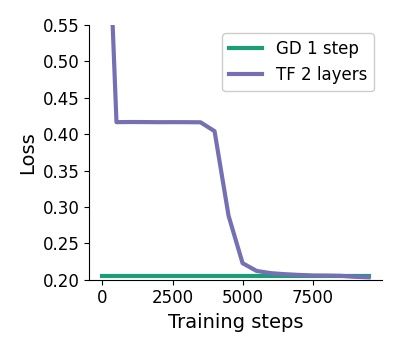

In [14]:
#@title Visualize Loss
losses_gd_list = [0.20468888]*len(loss_trans_list[0]) 
other_list_half = [o[:100] for o in other_list]
own_list_half = [o[:100] for o in own_list]
own_one_list_half = [o[:100] for o in own_one_list]
display_learning(loss_trans_list, [losses_gd_list], y_lim_u=0.55, y_lim_l=0.2,
                 loc_first='upper right', color_add=0.0, title2='GD 1 step', title1="TF 2 layers",
                 rw=1, title="train.pdf", allow_download=False, single_seeds=True,
                 num_iter_os=len(losses_gd_list)*500)

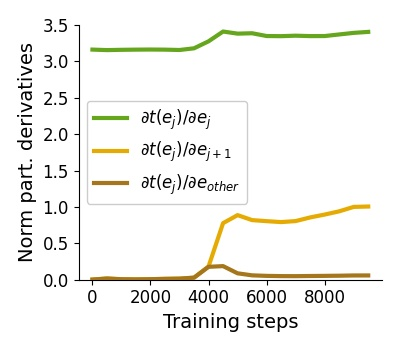

In [15]:
#@title Visualize sensitivity
display_learning(other_list_half, own_list_half, own_one_list_half, y_lim_u=3.5, y_lim_l=0.0,
                title3=r"$\partial t(e_j) / \partial e_{j+1}$", title2="$\partial t(e_j) / \partial e_{j}$", title1="$\partial t(e_j) / \partial e_{other}$",
                 loc_first='center left', color_add=0.5, label_title="Norm part. derivatives",
                 rw=1, title="train.pdf", allow_download=False, single_seeds=True,
                 num_iter_os=len(losses_gd_list)*500)

/tmp/ipykernel_917845/2860114520.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = pl.cm.get_cmap('Dark2')


Layer  0 Head  0


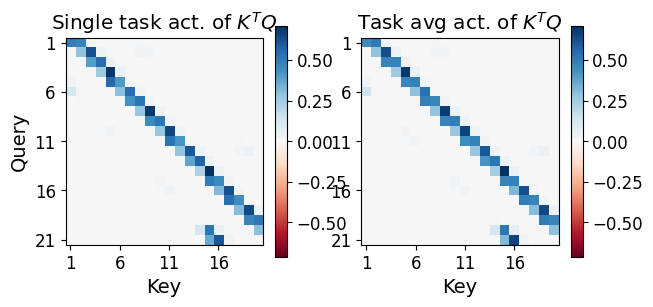

Layer  1 Head  0


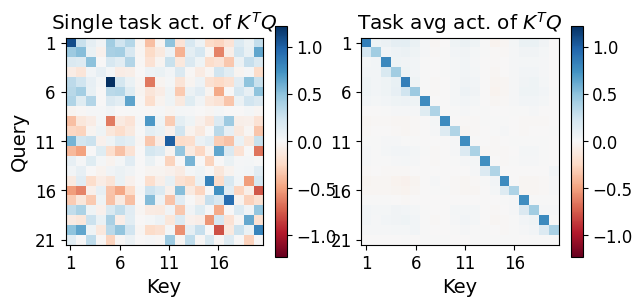

In [16]:
#@title Visualize attn heads
pl.rcParams.update({'font.size': 12})
pl.rc('axes', labelsize=14)
pl.rcParams.update({
    "text.usetex": False,
})


attn = predict_attn.apply(train_state.params, eval_rng,
                                            eval_data[0], False)

import matplotlib.colors as mcolors
colors = pl.cm.get_cmap('Dark2')

for n in range(config.num_layers):
  for head in range(attn[n].shape[1]):
    print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(7, 3), ncols=2)
    ax1.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax1.set_yticklabels(range(1, config.key_size+2, 5))
    ax1.set_xticks(ticks=range(0, config.key_size, 5))
    ax1.set_xticklabels(range(1, config.key_size+1, 5))

    ax2.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax2.set_yticklabels(range(1, config.key_size+2, 5))
    ax2.set_xticks(ticks=range(0, config.key_size, 5))
    ax2.set_xticklabels(range(1, config.key_size+1, 5))
    
    ax1.set_xlabel("Key")
    ax1.set_title("Single task act. of $K^TQ$")
    ax1.set_ylabel("Query")
    ax2.set_xlabel("Key")
    ax2.set_title("Task avg act. of $K^TQ$")
    single = jnp.squeeze(attn[n][0, head, :, :])
    mean = jnp.mean(attn[n][:, head, :, :], axis=0)
    vmin = jnp.max(jnp.abs(single))
    vmin2 = jnp.max(jnp.abs(mean))
    vmin = np.max([vmin, vmin2])
    pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pos = ax2.imshow(mean, cmap='RdBu', vmin=-vmin, vmax=vmin)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()

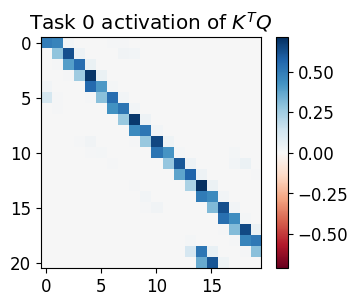

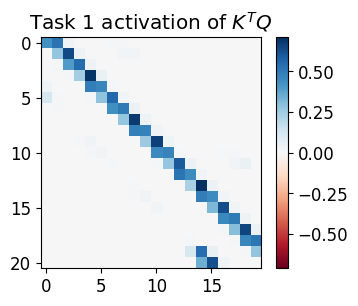

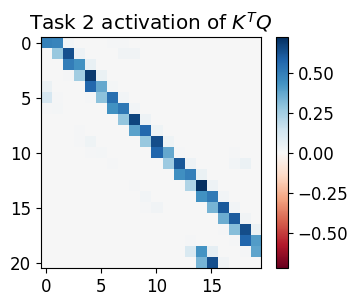

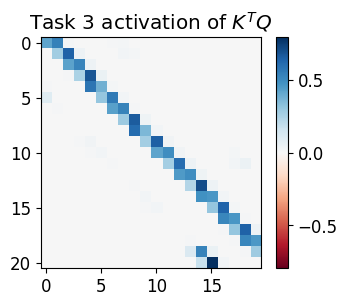

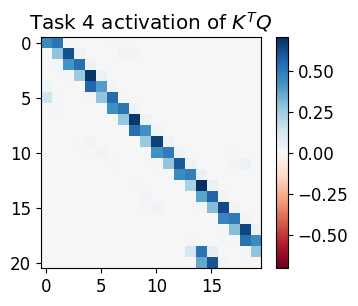

In [17]:
#@title Visualize attn heads for single tasks for layer 1

for i in range(5):
  fig, ax1 = pl.subplots(figsize=(4, 3))
  ax1.set_title("Task " + str(i) + " activation of $K^TQ$")
  single = jnp.squeeze(attn[0][i, 0, :, :])
  vmin = jnp.max(jnp.abs(single))
  pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin,)
  fig.colorbar(pos, ax=ax1, shrink=1)
  pl.show()

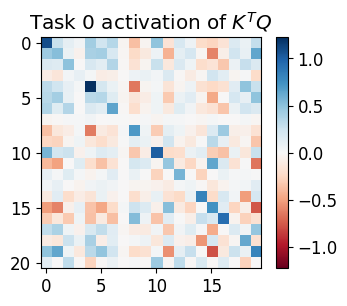

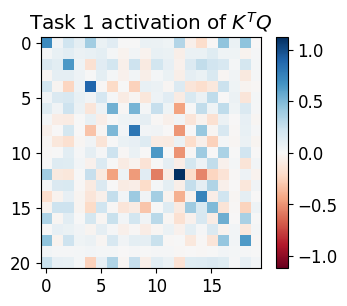

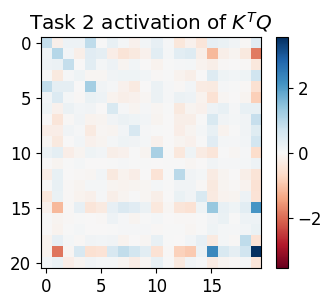

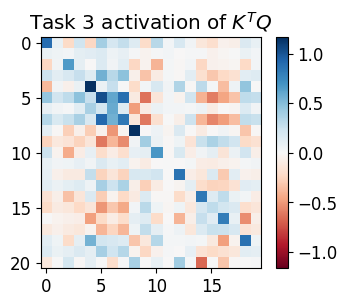

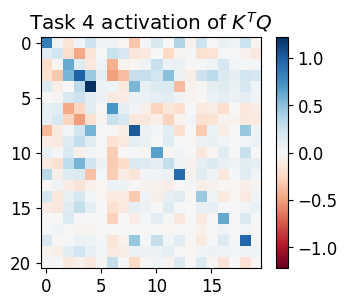

In [18]:
#@title Visualize attn heads for single tasks for layer 2

for i in range(5):
  fig, ax1 = pl.subplots(figsize=(4, 3))
  ax1.set_title("Task " + str(i) + " activation of $K^TQ$")
  single = jnp.squeeze(attn[1][i, 0, :, :])
  vmin = jnp.max(jnp.abs(single))
  pos = ax1.imshow(single, cmap='RdBu', vmin=-vmin, vmax=vmin,)
  fig.colorbar(pos, ax=ax1, shrink=1)
  pl.show()

Layer  0 Head  0


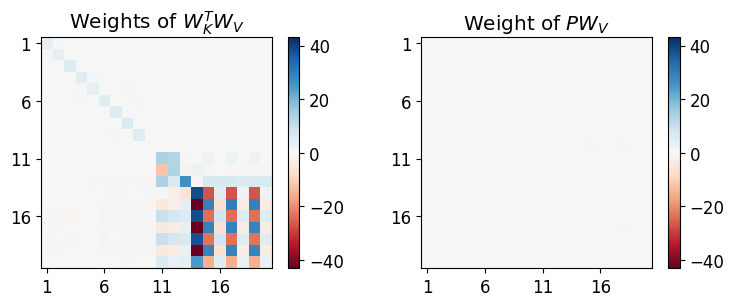

Layer  1 Head  0


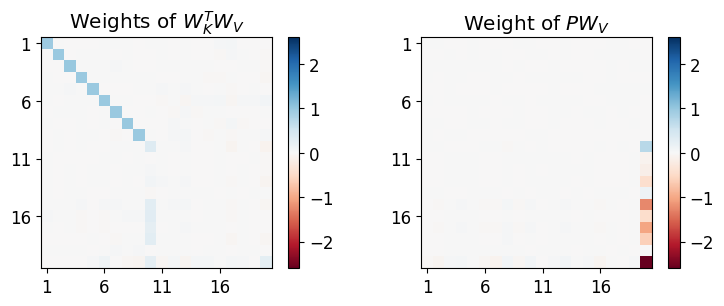

In [19]:
#@title Visualize weights
num_dim = config.key_size
for n in range(config.num_layers):
  for head in range(config.num_heads):
    KQ = jnp.identity(num_dim)
    LV = jnp.identity(num_dim)
    print("Layer ", n, "Head ", head)
    fig, (ax1, ax2) = pl.subplots(figsize=(9, 3), ncols=2)
  
    ax1.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax1.set_yticklabels(range(1, config.key_size+2, 5))
    ax1.set_xticks(ticks=range(0, config.key_size, 5))
    ax1.set_xticklabels(range(1, config.key_size+1, 5))

    ax2.set_yticks(ticks=range(0, config.key_size+1, 5))
    ax2.set_yticklabels(range(1, config.key_size+2, 5))
    ax2.set_xticks(ticks=range(0, config.key_size, 5))
    ax2.set_xticklabels(range(1, config.key_size+1, 5))

    for k,v in train_state.params.items():
      if str(n) in k:
        #print(k, head, v['w'].shape)
        #print(k, head, v['w'].shape, )
        if "key" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim])
        elif "query" in k:
          KQ = jnp.matmul(KQ, v['w'][:, head*num_dim: (head+1)*num_dim].T)
        elif "value" in k:
          LV = jnp.matmul(v['w'][:, head*num_dim: (head+1)*num_dim], LV)
        elif "linear" in k:
          LV = jnp.matmul(v['w'][head*num_dim: (head+1)*num_dim, :], LV)

    vmin = jnp.max(jnp.abs(KQ))
    vmin2 = jnp.max(jnp.abs(LV))
    vmin = np.max([vmin, vmin2])

    ax2.set_title("Weight of $PW_V$")
    ax1.set_title("Weights of $W^T_KW_V$")  
    pos = ax1.imshow(KQ,cmap='RdBu', vmin=-vmin, vmax=vmin,)
    fig.colorbar(pos, ax=ax1, shrink=1)
    pos = ax2.imshow(LV, cmap='RdBu', vmin=-vmin, vmax=vmin,)
    fig.colorbar(pos, ax=ax2, shrink=1)
    pl.show()

# s5

In [20]:
from jax.scipy.linalg import block_diag
from s5.multi_ssm import init_multi_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from ml_collections import config_dict

In [21]:
args = config_dict.ConfigDict()
args.ssm_size_base = 384
args.blocks = 3
args.conj_sym = False
args.d_model = 10
args.C_init = "lecun_normal"
args.discretization = "zoh"
args.dt_min = 0.001
args.dt_max = 0.1
args.bidirectional = False
args.clip_eigs = True
args.activation_fn = None
args.p_dropout = 0.
args.mode= "last"
args.prenorm = False
args.batchnorm = False
args.n_layers = 5
args.d_output = 10
args.jax_seed = 42
args.lr = 1e-3
args.lr_min = 0.
args.bsz = 2048
args.weight_decay= 0.05
args.opt_config = "standard"
args.dt_global = False
args.epochs = 1000
args.warmup_end = 1
args.dataset = "D2_scalar"

retrieval = False
padded = False
seq_len = config.dataset_size
in_dim = 10 # Before embedding
padded = False
lr = args.lr
ssm_lr = 0.1 * lr #FIXME - hardcode

In [22]:
use_wandb = False

In [23]:
if use_wandb:
    import wandb
    wandb.init(
    # set the wandb project where this run will be logged
    project="icl_s5",
    entity = "evnn-neurips",
    # track hyperparameters and run metadata
    config=args
    )

In [24]:
ssm_size = args.ssm_size_base
block_size = int(ssm_size / args.blocks)

In [25]:
# Initialize state matrix A using approximation to HiPPO-LegS matrix
Lambda, _, B, V, B_orig = make_DPLR_HiPPO(block_size)

if args.conj_sym:
    block_size = block_size // 2
    ssm_size = ssm_size // 2

Lambda = Lambda[:block_size]
V = V[:, :block_size]
Vc = V.conj().T

# If initializing state matrix A as block-diagonal, put HiPPO approximation
# on each block
Lambda = (Lambda * np.ones((args.blocks, block_size))).ravel()
V = block_diag(*([V] * args.blocks))
Vinv = block_diag(*([Vc] * args.blocks))

print("Lambda.shape={}".format(Lambda.shape))
print("V.shape={}".format(V.shape))
print("Vinv.shape={}".format(Vinv.shape))

Lambda.shape=(384,)
V.shape=(384, 384)
Vinv.shape=(384, 384)


In [26]:
Lambda

Array([-0.49999818-5.21466553e+03j, -0.49999818-1.73682605e+03j,
       -0.49999818-1.04042273e+03j, -0.49999818-7.41369263e+02j,
       -0.49999818-5.74768433e+02j, -0.49999818-4.68376465e+02j,
       -0.49999818-3.94407440e+02j, -0.49999818-3.39895264e+02j,
       -0.49999818-2.97975922e+02j, -0.49999818-2.64675842e+02j,
       -0.49999818-2.37535431e+02j, -0.49999818-2.14950775e+02j,
       -0.49999818-1.95831589e+02j, -0.49999818-1.79410645e+02j,
       -0.49999818-1.65132538e+02j, -0.49999818-1.52585312e+02j,
       -0.49999818-1.41456985e+02j, -0.49999818-1.31506958e+02j,
       -0.49999818-1.22546730e+02j, -0.49999818-1.14426491e+02j,
       -0.49999818-1.07025719e+02j, -0.49999818-1.00246391e+02j,
       -0.49999818-9.40078812e+01j, -0.49999818-8.82433319e+01j,
       -0.49999818-8.28968582e+01j, -0.49999818-7.79212875e+01j,
       -0.49999818-7.32766571e+01j, -0.49999818-6.89287643e+01j,
       -0.49999818-6.48482513e+01j, -0.49999818-6.10097809e+01j,
       -0.49999818-5.7391

In [27]:
ssm_init_fn = init_multi_S5SSM(H=args.d_model,
                             P=ssm_size,
                             Lambda_re_init=Lambda.real,
                             #Lambda_im_init=Lambda.imag,
                             V=V,
                             Vinv=Vinv,
                             C_init=args.C_init,
                             discretization=args.discretization,
                             dt_min=args.dt_min,
                             dt_max=args.dt_max,
                             conj_sym=args.conj_sym,
                             clip_eigs=args.clip_eigs,
                             bidirectional=args.bidirectional)

In [28]:
from tqdm import tqdm
from jax import random
from flax import linen as nn
from s5.train_helpers import create_train_state,reduce_lr_on_plateau,\
    linear_warmup, cosine_annealing, constant_lr, train_epoch, validate

In [29]:
class S5layer(nn.Module):
    """ Defines a single S5 layer, with S5 SSM, nonlinearity,
            dropout, batch/layer norm, etc.
        Args:
            ssm         (nn.Module): the SSM to be used (i.e. S5 ssm)
            dropout     (float32):  dropout rate
            d_model     (int32):    this is the feature size of the layer inputs and outputs
                                    we usually refer to this size as H
            activation  (string):   Type of activation function to use
            training    (bool):     whether in training mode or not
            prenorm     (bool):     apply prenorm if true or postnorm if false
            batchnorm   (bool):     apply batchnorm if true or layernorm if false
            bn_momentum (float32):  the batchnorm momentum if batchnorm is used
            step_rescale  (float32):  allows for uniformly changing the timescale parameter,
                                    e.g. after training on a different resolution for
                                    the speech commands benchmark
    """
    ssm: nn.Module
    dropout: float
    d_model: int
    activation: str = "gelu"
    training: bool = True
    prenorm: bool = False
    batchnorm: bool = False
    bn_momentum: float = 0.90
    step_rescale: float = 1.0
    use_skip: bool = False
    local_attn:bool= False

    def setup(self):
        """Initializes the ssm, batch/layer norm and dropout
        """
        self.seq = self.ssm(step_rescale=self.step_rescale)

        if self.activation in ["full_glu"]:
            self.out1 = nn.Dense(self.d_model)
            self.out2 = nn.Dense(self.d_model)
        elif self.activation in ["half_glu1", "half_glu2"]:
            self.out2 = nn.Dense(self.d_model)

        if self.batchnorm:
            self.norm = nn.BatchNorm(use_running_average=not self.training,
                                     momentum=self.bn_momentum, axis_name='batch')
        else:
            self.norm = nn.LayerNorm()

        self.drop = nn.Dropout(
            self.dropout,
            broadcast_dims=[0],
            deterministic=not self.training,
        )

    def __call__(self, x):
        """
        Compute the LxH output of S5 layer given an LxH input.
        Args:
             x (float32): input sequence (L, d_model)
        Returns:
            output sequence (float32): (L, d_model)
        """
        skip = x
        if self.prenorm:
            x = self.norm(x)
        x = self.seq(x)

        if self.activation in ["full_glu"]:
            x = self.drop(nn.gelu(x))
            x = self.out1(x) * jax.nn.sigmoid(self.out2(x))
            x = self.drop(x)
        elif self.activation in ["half_glu1"]:
            x = self.drop(nn.gelu(x))
            x = x * jax.nn.sigmoid(self.out2(x))
            x = self.drop(x)
        elif self.activation in ["half_glu2"]:
            # Only apply GELU to the gate input
            x1 = self.drop(nn.gelu(x))
            x = x * jax.nn.sigmoid(self.out2(x1))
            x = self.drop(x)
        elif self.activation in ["gelu"]:
            x = self.drop(nn.gelu(x))
        elif self.activation in [None]:
            x = x
        else:
            raise NotImplementedError(
                   "Activation: {} not implemented".format(self.activation))
        if self.use_skip:
            x = skip + x
        if not self.prenorm:
            x = self.norm(x)
        return x

In [30]:
class S5Model(nn.Module):
    """ Defines a stack of S5 layers to be used as an encoder.
        Args:
            ssm         (nn.Module): the SSM to be used (i.e. S5 ssm)
            d_model     (int32):    this is the feature size of the layer inputs and outputs
                                     we usually refer to this size as H
            n_layers    (int32):    the number of S5 layers to stack
            activation  (string):   Type of activation function to use
            dropout     (float32):  dropout rate
            training    (bool):     whether in training mode or not
            prenorm     (bool):     apply prenorm if true or postnorm if false
            batchnorm   (bool):     apply batchnorm if true or layernorm if false
            bn_momentum (float32):  the batchnorm momentum if batchnorm is used
            step_rescale  (float32):  allows for uniformly changing the timescale parameter,
                                    e.g. after training on a different resolution for
                                    the speech commands benchmark
    """
    ssm: nn.Module
    d_model: int
    n_layers: int
    activation: str = "gelu"
    dropout: float = 0.0
    training: bool = True
    prenorm: bool = False
    batchnorm: bool = False
    bn_momentum: float = 0.9
    step_rescale: float = 1.0

    def setup(self):
        """
        Initializes a linear encoder and the stack of S5 layers.
        """
        self.encoder = nn.Dense(self.d_model)
        self.Q = self.param('Q', nn.initializers.normal(stddev=0.1), (3, 3))
        self.layers = [
            S5layer(
                ssm=self.ssm,
                dropout=self.dropout,
                d_model=self.d_model,
                activation=self.activation,
                training=self.training,
                prenorm=self.prenorm,
                batchnorm=self.batchnorm,
                bn_momentum=self.bn_momentum,
                step_rescale=self.step_rescale,
            )
            for _ in range(self.n_layers)
        ]

    def __call__(self, x, integration_timesteps):
        """
        Compute the LxH output of the stacked encoder given an Lxd_input
        input sequence.
        Args:
             x (float32): input sequence (L, d_input)
        Returns:
            output sequence (float32): (L, d_model)
        """
        #x = self.encoder(x) # In normal token setup, this is Self attention
        # Create the collection of matrices using advanced slicing
        n = 3  # number of elements in each matrix
        stride = 2  # step size between the start of each matrix

        # Calculate the number of windows
        num_windows = (len(x) - n) // stride + 1

        # Use jax.vmap to create the sliding windows
        indices = jnp.arange(num_windows)[:, None] * stride + jnp.arange(n)
        matrices = x[indices]
        def compute_operation(E_i):
            return E_i.T @ self.Q @ E_i  #FIXME - check the dimensions again
        E_Q_E_T  = jax.vmap(compute_operation)(matrices)

        for layer in self.layers:
            x = layer(x)
        return x


# Here we call vmap to parallelize across a batch of input sequences
BatchS5Model = nn.vmap(
    S5Model,
    in_axes=(0, 0),
    out_axes=0,
    variable_axes={"params": None, "dropout": None, 'batch_stats': None, "cache": 0, "prime": None},
    split_rngs={"params": False, "dropout": True}, axis_name='batch')

In [31]:
model_cls = partial(
            BatchS5Model,
            ssm=ssm_init_fn,
            d_model=args.d_model,
            n_layers=args.n_layers,
            activation=args.activation_fn,
            dropout=args.p_dropout,
#            mode=args.mode,
            prenorm=args.prenorm,
            batchnorm=args.batchnorm,
        )

In [32]:
# Set randomness...
key = random.PRNGKey(args.jax_seed)
init_rng, train_rng = random.split(key, num=2)

In [33]:
state = create_train_state(model_cls,
                               init_rng,
                               padded,
                               retrieval,
                               in_dim=in_dim,
                               bsz=args.bsz,
                               seq_len=seq_len,
                               weight_decay=args.weight_decay,
                               batchnorm=args.batchnorm,
                               opt_config=args.opt_config,
                               ssm_lr=ssm_lr,
                               lr=lr,
                               dt_global=args.dt_global)

configuring standard optimization setup
[*] Trainable Parameters: 42399


In [34]:
state.params['layers_0']['seq'].keys()

dict_keys(['B', 'C', 'D', 'Lambda_re', 'log_step'])

In [35]:
state.params

{'Q': Array([[-0.06368469,  0.0078958 ,  0.02532892],
        [ 0.06377418, -0.14062582, -0.02940156],
        [-0.05525604, -0.06038569,  0.04326294]], dtype=float32),
 'layers_0': {'norm': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
   'scale': Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)},
  'seq': {'B': Array([[-0.00705695, -0.01421153, -0.04247907, ...,  0.03297783,
            0.04761282, -0.01878722],
          [ 0.02530163,  0.00222774, -0.03873523, ...,  0.03458069,
            0.04707536, -0.02273966],
          [ 0.0002853 , -0.04199561,  0.00507243, ..., -0.06235506,
            0.01834533,  0.09393846],
          ...,
          [ 0.080957  , -0.00461826,  0.06880727, ...,  0.0337959 ,
           -0.02295318,  0.0019676 ],
          [-0.03139545, -0.00262287, -0.00952363, ..., -0.02250316,
           -0.03394964,  0.0874562 ],
          [ 0.01304156, -0.02675265, -0.05085477, ..., -0.08986027,
           -0.04893612,  0.0050909

In [36]:
@partial(jax.jit, static_argnums=(5, 6))
def train_step(state,
               rng,
               batch_inputs,
               batch_labels,
               batch_integration_timesteps,
               model,
               batchnorm,
               ):
    """Performs a single training step given a batch of data"""
    def loss_fn(params):

        if batchnorm:
            logits, mod_vars = model.apply(
                {"params": params, "batch_stats": state.batch_stats},
                batch_inputs, batch_integration_timesteps,
                rngs={"dropout": rng},
                mutable=["intermediates", "batch_stats"],
            )
        else:
            logits, mod_vars = model.apply(
                {"params": params},
                batch_inputs, batch_integration_timesteps,
                rngs={"dropout": rng},
                mutable=["intermediates"],
            )
        logits = (logits[:,-1])*-1
        logits = logits[:,-1]
        loss = compute_loss(logits, batch_labels[:,-1])

        return loss, (mod_vars, logits)

    (loss, (mod_vars, logits)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)

    if batchnorm:
        state = state.apply_gradients(grads=grads, batch_stats=mod_vars["batch_stats"])
    else:
        state = state.apply_gradients(grads=grads)
    return state, loss


@partial(jax.jit, static_argnums=(4, 5))
def eval_step(batch_inputs,
              batch_labels,
              batch_integration_timesteps,
              state,
              model,
              batchnorm,
              ):
    if batchnorm:
        logits = model.apply({"params": state.params, "batch_stats": state.batch_stats},
                             batch_inputs, batch_integration_timesteps,
                             )
    else:
        logits = model.apply({"params": state.params},
                             batch_inputs, batch_integration_timesteps,
                             )
    logits = (logits[:,-1])*-1
    logits,batch_labels = logits[:,-1],batch_labels[:,-1]
    losses = compute_loss(logits, batch_labels)
    #accs = compute_accuracy(logits, batch_labels)

    return losses, logits

In [37]:
def compute_loss(preds, targets):
  assert preds.shape == targets.shape
  return 0.5*jnp.sum((targets-preds)**2)/targets.shape[0]

In [38]:
def train_epoch(state, rng, model, trainloader, seq_len, in_dim, batchnorm, lr_params):
    """
    Training function for an epoch that loops over batches.
    """
    # Store Metrics
    model = model(training=True)
    batch_losses = []

    decay_function, ssm_lr, lr, step, end_step, opt_config, lr_min = lr_params

    for batch_idx, batch in enumerate(trainloader):
        #inputs, labels, integration_times = prep_batch(batch, seq_len, in_dim)
        inputs, labels, _ = trainloader
        integration_times = np.ones((len(inputs), seq_len))
        rng, drop_rng = jax.random.split(rng)
        state, loss = train_step(
            state,
            drop_rng,
            inputs,
            labels,
            integration_times,
            model,
            batchnorm,
        )
        batch_losses.append(loss)
        lr_params = (decay_function, ssm_lr, lr, step, end_step, opt_config, lr_min)
        #state, step = update_learning_rate_per_step(lr_params, state)

    # Return average loss over batches
    return state, np.mean(np.array(batch_losses)), step



In [39]:
def validate(state, model, testloader, seq_len, in_dim, batchnorm, step_rescale=1.0):
    """Validation function that loops over batches"""
    model = model(training=False, step_rescale=step_rescale)
    losses, accuracies, preds = np.array([]), np.array([]), np.array([])
    for batch_idx, batch in enumerate(testloader):
        inputs, labels, _ = testloader
        integration_timesteps = np.ones((len(inputs), seq_len))
        loss, _ = eval_step(inputs, labels, integration_timesteps, state, model, batchnorm)
        losses = np.append(losses, loss)

    aveloss = np.mean(losses)    
    return aveloss

In [40]:
train_size = len(train_data[0])
trainloader = train_data

In [41]:
# Training Loop over epochs
ls_trainloss, ls_valloss = [],[]
best_loss, best_acc, best_epoch = 100000000, -100000000.0, 0  # This best loss is val_loss
count, best_val_loss = 0, 100000000  # This line is for early stopping purposes
lr_count, opt_acc = 0, -100000000.0  # This line is for learning rate decay
step = 0  # for per step learning rate decay
steps_per_epoch = int(train_size/args.bsz)
for epoch in range(args.epochs):
    #print(f"[*] Starting Training Epoch {epoch + 1}...")

    if epoch < args.warmup_end:
        print("using linear warmup for epoch {}".format(epoch+1))
        decay_function = linear_warmup
        end_step = steps_per_epoch * args.warmup_end

    # elif args.cosine_anneal:
    #     print("using cosine annealing for epoch {}".format(epoch+1))
    #     decay_function = cosine_annealing
        # for per step learning rate decay
        end_step = steps_per_epoch * args.epochs - (steps_per_epoch * args.warmup_end)
    else:
        #print("using constant lr for epoch {}".format(epoch+1))
        decay_function = constant_lr
        end_step = None

    # TODO: Switch to letting Optax handle this.
    #  Passing this around to manually handle per step learning rate decay.
    lr_params = (decay_function, ssm_lr, lr, step, end_step, args.opt_config, args.lr_min)

    train_rng, skey = random.split(train_rng)
    state, train_loss, step = train_epoch(state,
                                            skey,
                                            model_cls,
                                            trainloader,
                                            seq_len,
                                            in_dim,
                                            args.batchnorm,
                                            lr_params)
    val_loss = validate(state,
                                model_cls,
                                eval_data,
                                seq_len,
                                in_dim,
                                args.batchnorm)
    if use_wandb:
        wandb.log({"train_loss": train_loss, "val_loss": val_loss})
    ls_trainloss.append(train_loss)
    ls_valloss.append(val_loss)
    if (epoch+1) % 100 ==0:
            print(f"\n=>> Epoch {epoch + 1} Metrics ===")
            print(
                f"\tTrain Loss: {train_loss:.5f} -- Val Loss: {val_loss:.5f}"
            )

using linear warmup for epoch 1

=>> Epoch 100 Metrics ===
	Train Loss: 0.41204 -- Val Loss: 0.44137

=>> Epoch 200 Metrics ===
	Train Loss: 0.37694 -- Val Loss: 0.46390

=>> Epoch 300 Metrics ===
	Train Loss: 0.35122 -- Val Loss: 0.50655

=>> Epoch 400 Metrics ===
	Train Loss: 0.33780 -- Val Loss: 0.52334

=>> Epoch 500 Metrics ===
	Train Loss: 0.32686 -- Val Loss: 0.54077

=>> Epoch 600 Metrics ===
	Train Loss: 0.31973 -- Val Loss: 0.55154

=>> Epoch 700 Metrics ===
	Train Loss: 0.31478 -- Val Loss: 0.56226

=>> Epoch 800 Metrics ===
	Train Loss: 0.30897 -- Val Loss: 0.57120

=>> Epoch 900 Metrics ===
	Train Loss: 0.30467 -- Val Loss: 0.58126

=>> Epoch 1000 Metrics ===
	Train Loss: 0.30049 -- Val Loss: 0.58834


In [42]:
import matplotlib.pyplot as plt

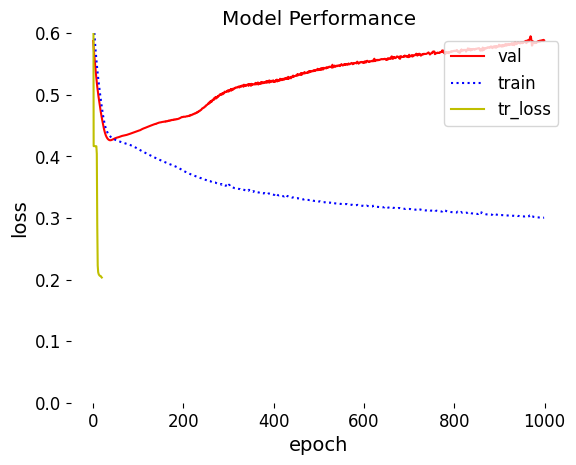

In [43]:
plt.plot(ls_valloss,color='r')
plt.plot(ls_trainloss,color='b',linestyle='dotted')
plt.plot(loss_trans_list[0],color='y')
plt.title('Model Performance')
plt.ylim(0,0.6)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['val', 'train','tr_loss'], loc='upper right')
plt.box(False)
plt.show()